In [1]:
import pickle as pkl
from typing import Dict, List, Tuple
import numpy as np
import xgboost as xgb
import shap

In [3]:
dtrain = xgb.DMatrix("local/data/train")
dval = xgb.DMatrix("local/data/validation")

watchlist = (
    [(dtrain, "train"), (dval, "validation")]
)

K = 3
def hit_rate_at_k(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Hit rate at K. Ratio of predictions where the correct label is in the top K most probable classes.
    '''
    y = dtrain.get_label()
    top_k_preds = predt.argsort(axis=1)[:, -K:]
    hits_mask = [(y[i] in top_k_preds[i]) for i in range(len(y))]
    num_hits = len(y[hits_mask])
    hit_rate_at_k = float(num_hits / len(y))
    return f'hit_rate_at_{K}', hit_rate_at_k

xgboost_train_params = {
    "disable_default_eval_metric": 1,
    "eta": 0.3,
    "objective": "multi:softprob",
    "num_class": 30,
    "subsample": 0.5
}

results: Dict[str, Dict[str, List[float]]] = {}
model = xgb.train(
    params=xgboost_train_params,
    dtrain=dtrain,
    evals=watchlist,
    feval=hit_rate_at_k,
    maximize=True,
    evals_result=results,
    num_boost_round=100,
    # stop early when the metric for the last dataset in evals has been worse than
    # the best value, this number of times
    early_stopping_rounds=5,
)

[0]	train-hit_rate_at_3:0.68361	validation-hit_rate_at_3:0.68732
[1]	train-hit_rate_at_3:0.73155	validation-hit_rate_at_3:0.72478
[2]	train-hit_rate_at_3:0.75251	validation-hit_rate_at_3:0.72046
[3]	train-hit_rate_at_3:0.76428	validation-hit_rate_at_3:0.72478
[4]	train-hit_rate_at_3:0.78610	validation-hit_rate_at_3:0.72190
[5]	train-hit_rate_at_3:0.79472	validation-hit_rate_at_3:0.73055
[6]	train-hit_rate_at_3:0.80362	validation-hit_rate_at_3:0.72767
[7]	train-hit_rate_at_3:0.81395	validation-hit_rate_at_3:0.73775
[8]	train-hit_rate_at_3:0.82429	validation-hit_rate_at_3:0.73487
[9]	train-hit_rate_at_3:0.83778	validation-hit_rate_at_3:0.72911
[10]	train-hit_rate_at_3:0.84353	validation-hit_rate_at_3:0.72911
[11]	train-hit_rate_at_3:0.84754	validation-hit_rate_at_3:0.72623
[12]	train-hit_rate_at_3:0.86161	validation-hit_rate_at_3:0.72190


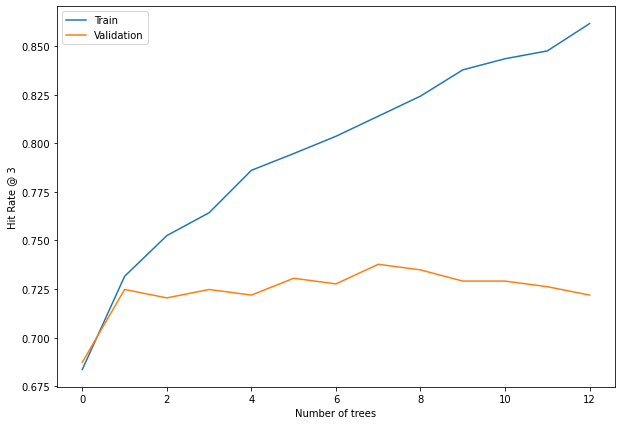

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(results["train"]["hit_rate_at_3"], label="Train")
plt.plot(results["validation"]["hit_rate_at_3"], label="Validation")
plt.xlabel("Number of trees")
plt.ylabel("Hit Rate @ 3")
plt.legend()

In [6]:
# Get the predictions for the validation set and verify the hit rate at k
y = dval.get_label()
pred = model.predict(dval)
top_k_preds = pred.argsort(axis=1)[:, -K:]
hits_mask = [(y[i] in top_k_preds[i]) for i in range(len(y))]
hit_rate_at_k = len(y[hits_mask]) / len(y)
hit_rate_at_k

0.7219020172910663

In [7]:
pkl.dump(model, open("model.pkl", "wb"))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

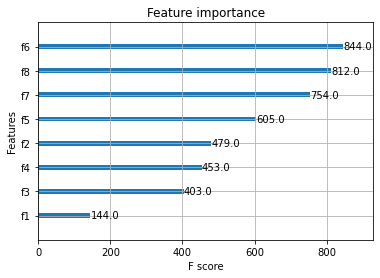

In [8]:
xgb.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

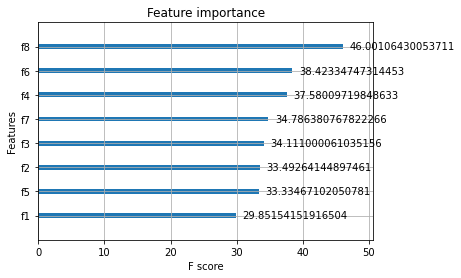

In [9]:
xgb.plot_importance(model, importance_type="cover")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

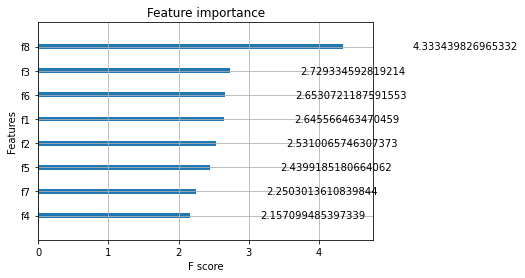

In [10]:
xgb.plot_importance(model, importance_type="gain")

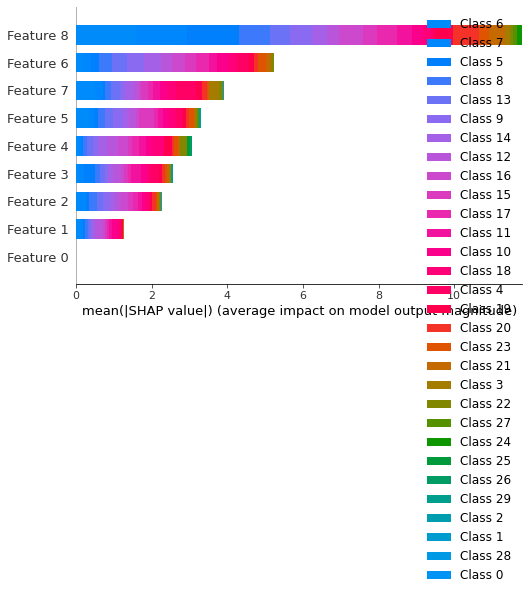

In [12]:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(dval)
shap.summary_plot(shap_values)